# **Data Analysis - AI vs Real: Human Face Authenticity Classifier**

---

### **1. Import the necessary libraries for analysis.**

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import cv2
import os
import random

- **os** → Used to navigate through dataset directories and list image files.
- **numpy** → Helps in handling image sizes and numerical computations.
- **matplotlib.pyplot & seaborn** → Used for visualizing dataset distributions.
- **tensorflow.keras.preprocessing.image** → Loads and converts images for analysis.

---

### **2. Define the dataset paths**

In [16]:
real_images_path = "C:/Users/anany/Downloads/AI_or_Real/dataset_root/Real Images"
ai_generated_path = "C:/Users/anany/Downloads/AI_or_Real/dataset_root/AI-Generated Images"

- Replace the given path inside the "" with the actual path where your dataset is stored.
- The dataset has two folders:
   - "Real Images" containing real human face images.
   - "AI-Generated Images" containing synthetic human faces.

---

### **3. Count and Visualize the Dataset Distribution**

C:\Users\anany\AppData\Local\Temp\ipykernel_5472\3333079486.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=counts, palette=["blue", "red"])


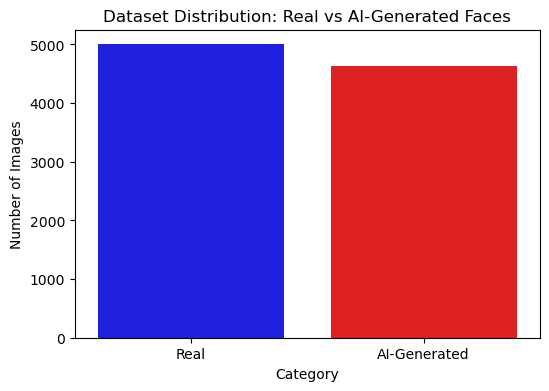

In [18]:
num_real_images = len(os.listdir(real_images_path))
num_ai_generated_images = len(os.listdir(ai_generated_path))

labels = ["Real", "AI-Generated"]
counts = [num_real_images, num_ai_generated_images]

plt.figure(figsize=(6, 4))
sns.barplot(x=labels, y=counts, palette=["blue", "red"])
plt.title("Dataset Distribution: Real vs AI-Generated Faces")
plt.xlabel("Category")
plt.ylabel("Number of Images")
plt.show()

---

### **4. Display the sample images from each category**

In [23]:
def show_sample_images(image_path, title, num_samples=5):
    sample_images = np.random.choice(os.listdir(image_path), num_samples)
    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(sample_images):
        img = load_img(os.path.join(image_path, img_name))
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

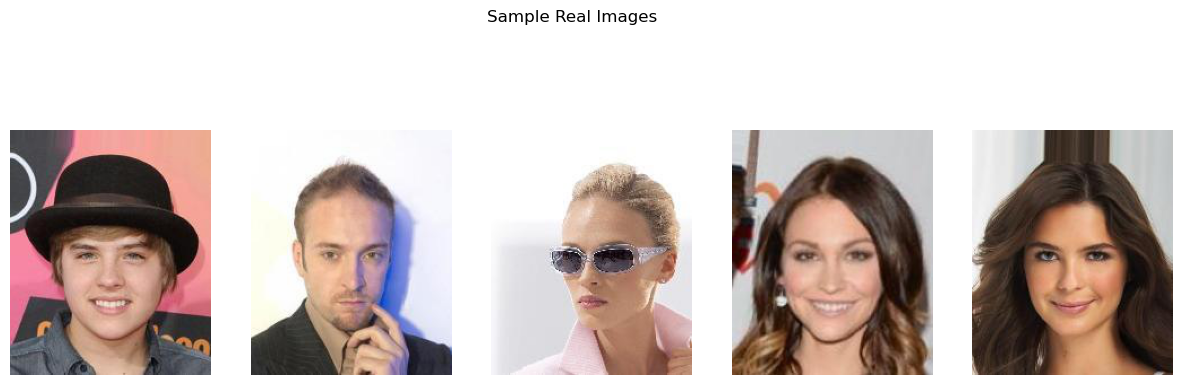

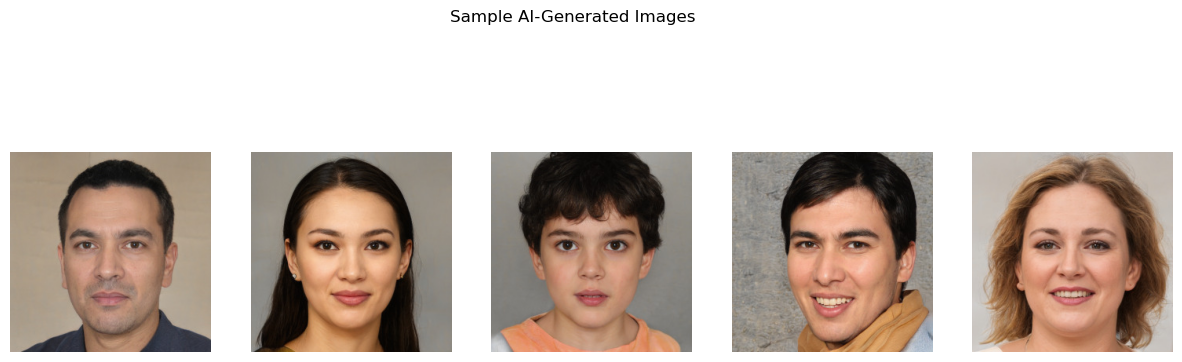

In [25]:
show_sample_images(real_images_path, "Sample Real Images")
show_sample_images(ai_generated_path, "Sample AI-Generated Images")

- This function randomly selects 5 images from a given category and displays them.
- Uses load_img() to open images and display them using Matplotlib.
- Helps visually inspect image quality and variations.

---

### **5. Checking image dimensions to ensure consistency**

In [33]:
def check_image_shapes(image_path, num_samples=100):
    shapes = []
    sample_images = np.random.choice(os.listdir(image_path), num_samples)
    for img_name in sample_images:
        img = load_img(os.path.join(image_path, img_name))
        shapes.append(img.size)  # (width, height)
    return shapes

- This function randomly selects 100 images from a category and extracts their dimensions (width, height).
- This helps verify whether all images are of the same size before resizing.

In [39]:
real_shapes = check_image_shapes(real_images_path)
ai_shapes = check_image_shapes(ai_generated_path)
print(real_shapes[0:5])
print(ai_shapes[0:5])

[(178, 218), (178, 218), (178, 218), (178, 218), (178, 218)]
[(256, 256), (256, 256), (256, 256), (256, 256), (256, 256)]


We can see that the dataset contains real images (178×218) and AI-generated images (256×256), meaning resizing is necessary for uniform input.

---

### **6. Visualize and Analyze**

#### **a. Color Distribution Analysis**

This analyzes the color intensity across images, which can help understand differences in AI vs real faces.
- Compute average RGB values for each image.
- Store results in a DataFrame with categories ("Real" or "AI-Generated").
- Plot histograms for Red, Green, and Blue color channels:
     - X-axis: Intensity values (0-255).
     - Hue: "Real" (Blue) vs. "AI-Generated" (Red).
     - Goal: Identify differences in color distribution.
- compute_avg_color(image_folder): Loads images from a folder, computes their average RGB values, and returns an array of mean color intensities.

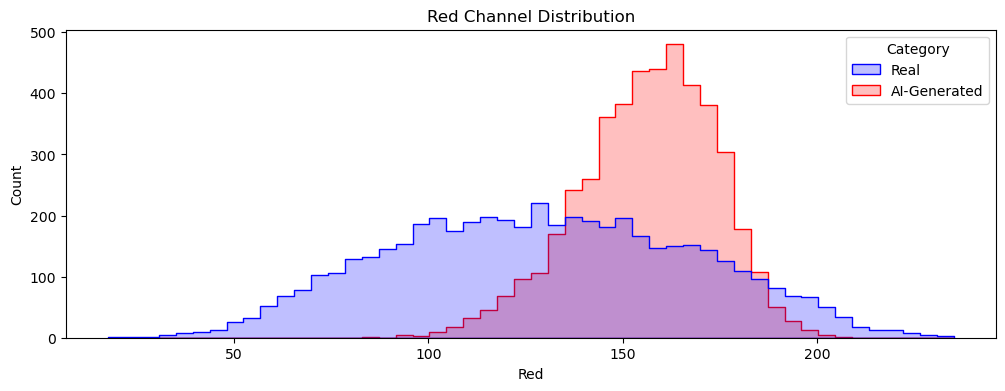

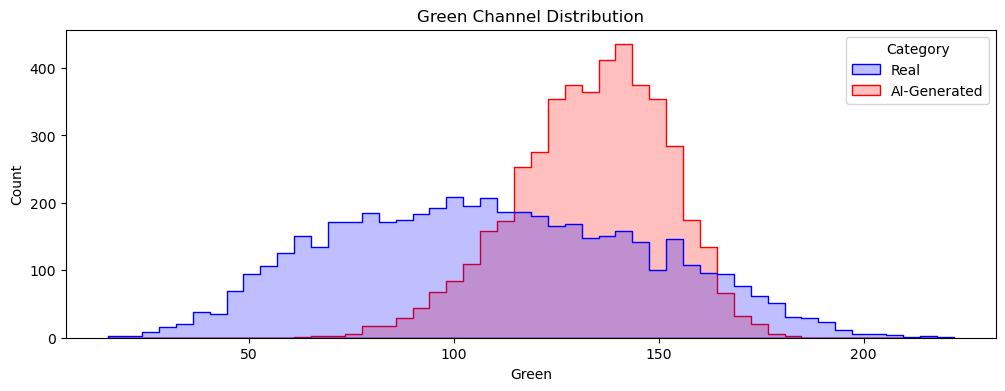

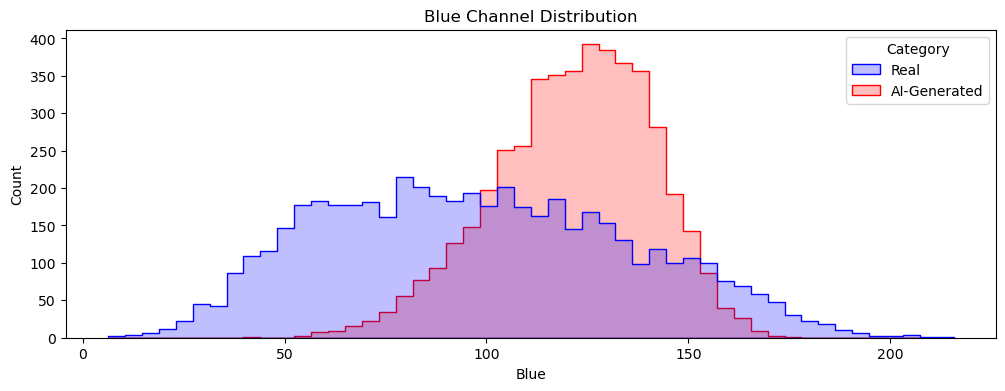

In [67]:
# Function to calculate average color intensities
def compute_avg_color(image_folder):
    avg_colors = []
    for img_name in os.listdir(image_folder):
        img_path = os.path.join(image_folder, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            avg_colors.append(np.mean(img, axis=(0, 1)))  # Average per channel
    return np.array(avg_colors)

# Compute average colors
real_avg_colors = compute_avg_color(real_images_path)
ai_avg_colors = compute_avg_color(ai_generated_path)

# Convert to DataFrame for easier plotting
df_colors = pd.DataFrame({
    "Red": np.concatenate([real_avg_colors[:, 2], ai_avg_colors[:, 2]]),
    "Green": np.concatenate([real_avg_colors[:, 1], ai_avg_colors[:, 1]]),
    "Blue": np.concatenate([real_avg_colors[:, 0], ai_avg_colors[:, 0]]),
    "Category": ["Real"] * len(real_avg_colors) + ["AI-Generated"] * len(ai_avg_colors)
})

# Plot histograms for each color channel
plt.figure(figsize=(12, 4))
sns.histplot(df_colors, x="Red", hue="Category", bins=50, element="step", palette={"Real": "blue", "AI-Generated": "red"})
plt.title("Red Channel Distribution")
plt.show()

plt.figure(figsize=(12, 4))
sns.histplot(df_colors, x="Green", hue="Category", bins=50, element="step", palette={"Real": "blue", "AI-Generated": "red"})
plt.title("Green Channel Distribution")
plt.show()

plt.figure(figsize=(12, 4))
sns.histplot(df_colors, x="Blue", hue="Category", bins=50, element="step", palette={"Real": "blue", "AI-Generated": "red"})
plt.title("Blue Channel Distribution")
plt.show()

**color(RGB) channel distribution**
- The histogram shows that "Real" images peak around a red, green and blue value of around 150, while "AI-Generated" images have a wider distribution.
- This indicates significant differences in the color (RGB) channel intensity between the two types.
- This shows that the AI-generated faces have unnatural color intensities. Some AI-generated faces have unnatural sharpness or lighting effects.

#### **b. Facial Feature Analysis**

- Select random images from real and AI-generated datasets.
- Convert images to grayscale for edge detection.
- Apply Canny edge detection (cv2.Canny with thresholds 100 & 200) to highlight edges.
- Display results side by side using matplotlib.
   - Left: Real face edges.
   - Right: AI-generated face edges.
   - Goal: Identify structural differences in edge patterns.

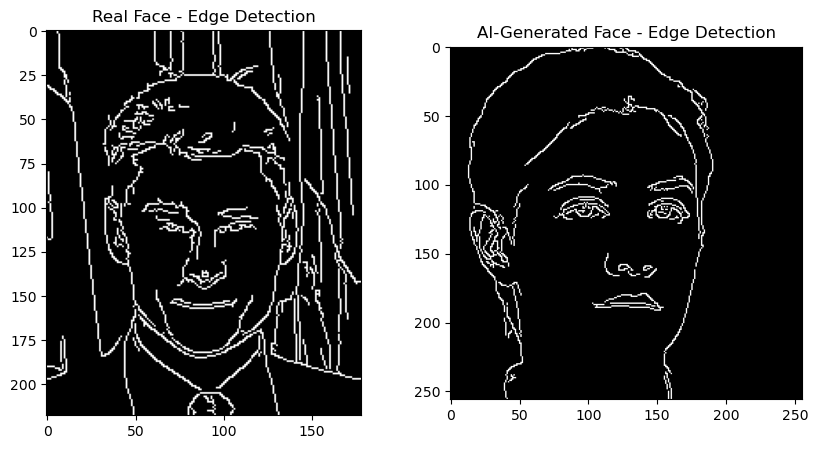

In [76]:
# Select random images
real_sample = random.choice(os.listdir(real_images_path))
ai_sample = random.choice(os.listdir(ai_generated_path))

real_img = cv2.imread(os.path.join(real_images_path, real_sample), cv2.IMREAD_GRAYSCALE)
ai_img = cv2.imread(os.path.join(ai_generated_path, ai_sample), cv2.IMREAD_GRAYSCALE)

# Apply Canny edge detection
real_edges = cv2.Canny(real_img, 100, 200)
ai_edges = cv2.Canny(ai_img, 100, 200)

# Display
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(real_edges, cmap="gray")
ax[0].set_title("Real Face - Edge Detection")
ax[1].imshow(ai_edges, cmap="gray")
ax[1].set_title("AI-Generated Face - Edge Detection")
plt.show()

- These edge detection images show notable differences between real and AI-generated faces.
- The real face has more pronounced and detailed edges, indicating clearer features and complexity. In contrast, the AI-generated face displays smoother, less defined edges, suggesting a simpler representation.
- This analysis underscores the varying characteristics in detail and structure between real and AI-generated images

---

### **Conclusion**

This analysis highlights key differences between real and AI-generated faces:

- Size: AI-generated images are uniform (256x256), while real images vary (178x218).
- Color: AI faces have unnatural color intensities, sharpness and lighting, whereas real faces show natural variation.
- Edges: AI faces have smoother, less defined edges and very simple representation, while real faces have  detailed edges, indicating clearer features and organic imperfections.

Author: Ananya P S